# Customer Churn Project

<b>Jeff Spagnola</b><br><br>
jeff.spags@gmail.com<br>
<a href="jeffspagnola.com">Portfolio Site</a><br>
<a href="github.com/spags093">Githube</a><br>
<a href="linkedin.com/in/jeffspagnola">LinkedIn</a>


## Introduction

<center><img src="2-8_telecom-media_v2_1600.jpg" alt="telecom image"></center>

Customer churn is a major concern for any business.  In today's world, the customer is more informed than ever and can find various offers and promotions for services with just a few taps on a mobile device.  With targeted social media ads, they may not even have to do that!  This fact alone makes it harder than ever to create a long-term customer when any misstep in customer management can send a loyal client jumping ship for a better offer somewhere else.  With so much competition in the telecom market, it's no surprise that many companies have issues with losing customers to competing companies.  Often, it is not 100% clear why these customers drop their current provider to leave for another.  

In this project, we will use data analysis and machine learning to figure out what factors most influence a customer's decision to leave their service provider for a competitor.  

### Imports

In [122]:
# The usuals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

# Sklearn Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Tensorflow modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# Model Evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, plot_roc_curve
import shap

# Show all columns 
pd.set_option('display.max_columns', None)

### Functions

#### Preprocessing Functions

In [2]:
def get_info(df):
    print(df.shape)
    display(df.describe())
    print(df.info())

#### Plotting Functions

In [95]:
def count_plot(data, x, title, xlabel, ylabel):
    ax = plt.figure(figsize = (12, 6))
    ax = sns.countplot(data = data, x = x)
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.tick_params(labelsize = 14);
    

def evaluate_model(model, X_test, y_test):
    '''Evaluates a sci-kit learn classification model and displays a classification report, 
    a confusion matrix, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix Plot
    fig, axes = plt.subplots(figsize = (12, 6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])
    
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show();
    
    
def network_eval_plots(results):
    history = results.history
    
    # Loss
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    

def nn_confusion_matrix(y_test, preds):
    labels = ['Churn', 'No Churn']
    cm = confusion_matrix(y_test, preds, normalize = 'true')
    ax = plt.figure(figsize = (6,6))
    ax = sns.heatmap(cm, cmap = 'Blues', annot = True, xticklabels = labels, 
                     yticklabels = labels)
    ax.set_ylim([0,2])
    
    
def evaluate_network(results, model, X_test, y_test):
    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    print('-------------------------------------------------------')
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print('-------------------------------------------------------')
    network_eval_plots(results)
    print(' ')
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, preds))
    print(' ')    
    print('                 Confusion Matrix')
    print('-------------------------------------------------------')
    nn_confusion_matrix(y_test, preds)

#### Modeling Functions

## Obtain

The data comes from the Churn In Telecom dataset from Kaggle. There isn't much more info on Kaggle than is represented in the dataset, but if you'd like to check it out, <a href="https://www.kaggle.com/becksddf/churn-in-telecoms-dataset">click here</a>.

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
print(df.shape)
df.head()

(3333, 21)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
get_info(df)

(3333, 21)


,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

## Scrub

### Null Values

In [5]:
# Checking for null values

df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

> Perfectly clean data in terms of nulls.  What are the odds of that? 

### Exploring the columns

There's a few red flags in the info, specifically:
- Phone number being an object, although do we even need the phone number column for prediction?
- One hot encoding the states may lead to too sparse of a dataset
- Area code should be come categorical as opposed to a numerical value
- Our target, churn, being a bool as opposed to a (1,0)

We can tackle these in order.

#### Phone Number Column

We can remove the phone number column as it has no bearing on the outcome. 

In [6]:
df.drop('phone number', axis = 1, inplace = True)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


#### State Value Counts

Let's check and see how many individual states are represented here.  We also need to consider that having both state and an area code could potentiall be redundant.

In [7]:
# Looka as though all 50 states are represented as well as Washington DC.  Let's leave this for now.

df['state'].value_counts()

WV    106
MN     84
NY     83
AL     80
OH     78
OR     78
WI     78
VA     77
WY     77
CT     74
MI     73
VT     73
ID     73
UT     72
TX     72
IN     71
MD     70
KS     70
NJ     68
MT     68
NC     68
WA     66
CO     66
NV     66
RI     65
MS     65
MA     65
AZ     64
MO     63
FL     63
ME     62
NM     62
ND     62
OK     61
DE     61
NE     61
SD     60
SC     60
KY     59
IL     58
NH     56
AR     55
DC     54
GA     54
TN     53
HI     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64

#### Area Code

In [8]:
# Let's double check the data type here

type(df['area code'][0])

numpy.int64

> As expected, this column is misrepresented as an integer when it should really be a string, making it categorical.  Can't exactly take an average of an area code.  Let's change this field to a string and also check for strange values.

In [9]:
# Checking the value counts

df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

> Hmmm...  Well that doesn't make too much sense.  These three area codes can't be available in every state, can they?  Let's check.

So after a quick google search, we can find that each of these area codes is from the bay area.  This a confusing development as there's no deeper explanation into this dataset.  Since there's no real explanation for this, we're going to drop the column and go with the state as the location metric. 

In [10]:
df.drop('area code', axis = 1, inplace = True)

### Checking for Unusual Values

#### Numerical Columns

In [11]:
# We can use .describe() to check for the min/max of numerical columns

df.describe()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [12]:
# There's a lot of 0 values as the minimum in here.  Let's check out one column and see if this is accurate.

df['total day minutes'].value_counts()

174.5    8
159.5    8
154.0    8
175.4    7
162.3    7
        ..
199.9    1
105.8    1
125.6    1
179.8    1
270.8    1
Name: total day minutes, Length: 1667, dtype: int64

In [13]:
df[df['total day minutes'] == 0]

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1345,SD,98,no,no,0,0.0,0,0.0,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4,True
1397,VT,101,no,no,0,0.0,0,0.0,192.1,119,16.33,168.8,95,7.60,7.2,4,1.94,1,False


> Seems legit enough.  We can leave this for now. 

### Target Column 

Target colum is 'churn' and is currently a bool as opposed to the binary target that we're looking for.  Let's go through and change this. 

In [14]:
# Checking value counts

df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [15]:
df['churn'] = pd.get_dummies(df['churn'])

In [16]:
df['churn'].value_counts()

1    2850
0     483
Name: churn, dtype: int64

### Data Preprocessing

Let's set up the preprocessing pipelines and get a final cleaned dataset.

#### Train/Test Split

In [17]:
X = df.drop('churn', axis = 1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

#### Sklearn Preprocessing

In [18]:
# Separateing columns into numerical and categorical

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('object').columns

print(num_cols)
print(cat_cols)

Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')
Index(['state', 'international plan', 'voice mail plan'], dtype='object')


In [19]:
# Setting numerical pipeline

num_transformer = Pipeline(steps = [('scaler', StandardScaler())])
num_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [20]:
# Setting categorical pipeline

cat_transformer = Pipeline(steps = [('encoder', OneHotEncoder(handle_unknown = 'ignore', sparse = False))])
cat_transformer

Pipeline(steps=[('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [21]:
# Creating and fitting column transformer

preprocessing = ColumnTransformer(transformers = [('num', num_transformer, num_cols),
                                                  ('cat', cat_transformer, cat_cols)])

X_train_trans = preprocessing.fit_transform(X_train)
X_test_trans = preprocessing.transform(X_test)

In [22]:
# Put the data back into a dataframe

slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)

X_train_df = pd.DataFrame(X_train_trans, columns = [*num_cols, *cat_features])
X_test_df = pd.DataFrame(X_test_trans, columns = [*num_cols, *cat_features])

In [23]:
# Checking X_train

X_train_df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,-0.028933,1.619646,-2.209903,0.201909,-2.209527,0.380157,0.331618,0.380678,-0.950039,0.913244,-0.951602,-1.121829,-0.607288,-1.118559,-1.200063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.449569,-0.592100,0.920122,0.851484,0.920282,0.490240,0.031341,0.491349,-0.042679,0.555661,-0.043821,-0.943317,0.605832,-0.946654,1.092718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2.791711,-0.592100,-0.984159,-0.197830,-0.984213,-1.124978,-1.019628,-1.123978,2.005757,0.095911,2.007414,-0.943317,-0.607288,-0.946654,-0.435803,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.003749,0.587498,-1.113665,0.601647,-1.114040,0.556290,-0.168843,0.557281,-0.404052,0.555661,-0.406061,-0.729104,0.201458,-0.735079,0.328458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.608173,-0.592100,-0.686843,0.601647,-0.687004,2.117466,0.531803,2.118451,-0.081958,-0.925754,-0.083100,-0.122165,-1.416035,-0.126800,-0.435803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [24]:
# Checking X_test

X_test_df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,0.172541,-0.5921,-0.469784,1.151288,-0.470267,-1.765460,-0.719351,-1.764458,0.898070,-1.283337,0.898874,1.841461,-0.202915,1.843493,1.856978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.111859,-0.5921,0.750488,0.052007,0.750755,0.724416,-1.770320,0.724465,1.013945,1.883826,1.012347,-0.264974,-1.416035,-0.259035,-1.200063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.867389,-0.5921,0.387507,1.401125,0.387024,0.534273,-0.018705,0.533734,-1.077698,-0.466005,-1.078168,-0.657699,-0.607288,-0.655738,0.328458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.305961,-0.5921,-0.767100,-0.197830,-0.767476,-0.158249,-1.870413,-0.158549,1.080720,1.270827,1.082176,0.270560,0.201458,0.269903,-0.435803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.751781,-0.5921,-1.224930,1.650961,-1.224555,-0.022146,0.782034,-0.021976,-1.138582,0.249161,-1.139269,-0.050760,0.201458,-0.047459,-1.200063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Explore

> Plots to use: Countplot, barplot, scatterplot?

In [138]:
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,1
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1


### Countplot of Customer Churn

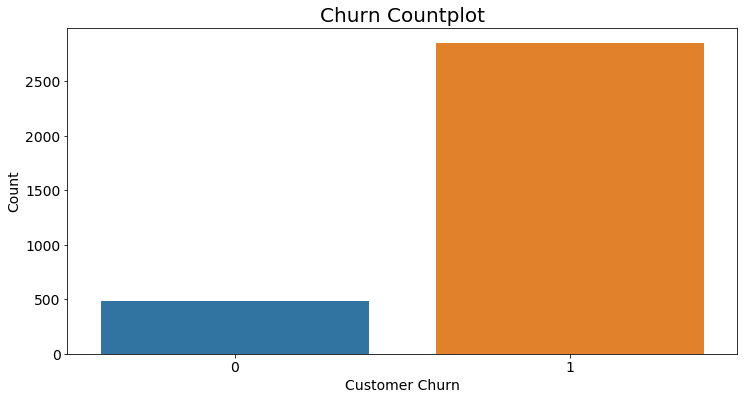

In [145]:
count_plot(df, 'churn', 'Churn Countplot', 'Customer Churn', 'Count')

### Customers by Customer Service Calls

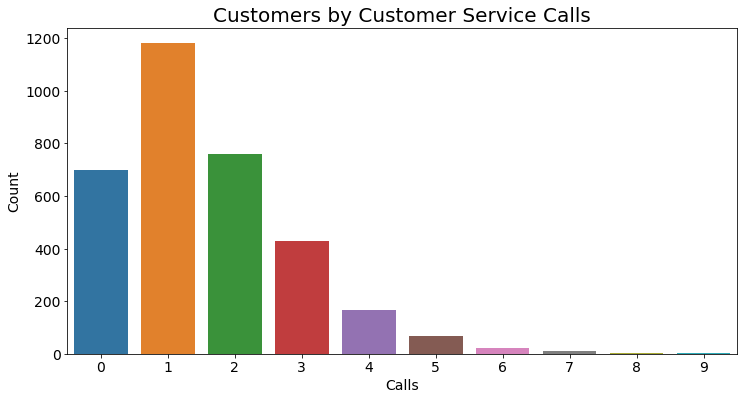

In [146]:
count_plot(df, 'customer service calls', 'Customers by Customer Service Calls', 'Calls', 'Count')

### Customers by Total International Calls

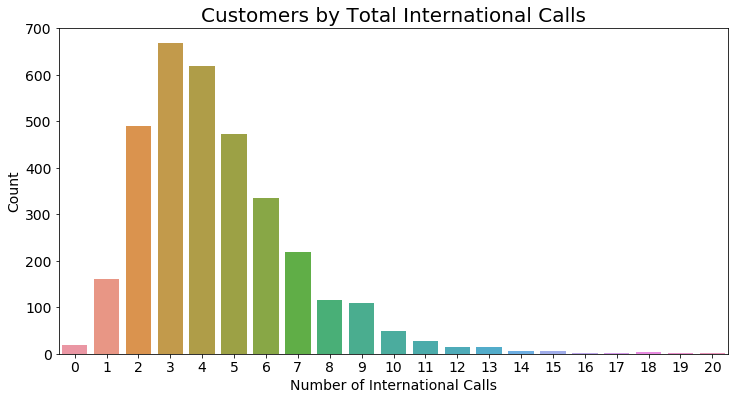

In [147]:
count_plot(df, 'total intl calls', 'Customers by Total International Calls', 
           'Number of International Calls', 'Count')

## Modeling

> Models to use: Logistic Regression, Random Forest, XGBoost, Stacking Classifier, Neural network

### Logistic Regression

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.69      0.44       121
           1       0.93      0.76      0.84       713

    accuracy                           0.75       834
   macro avg       0.63      0.72      0.64       834
weighted avg       0.85      0.75      0.78       834



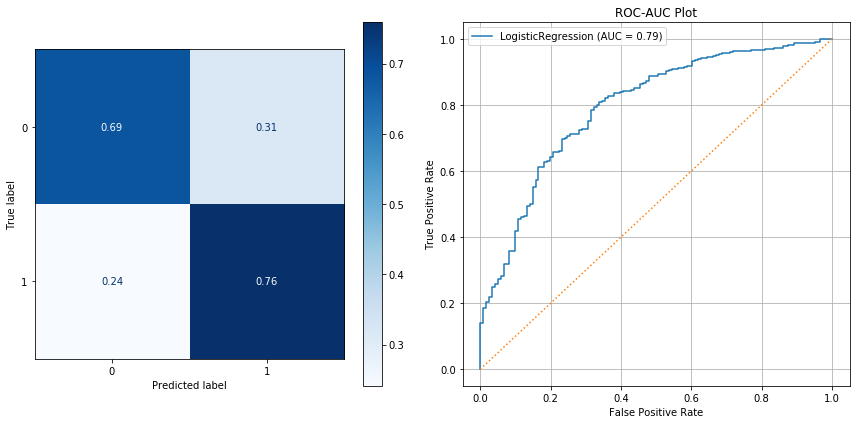

In [34]:
# Instantiat Model
logreg = LogisticRegression(class_weight = 'balanced')

# Fit model
logreg.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(logreg, X_test_df, y_test)

#### Gridsearch

In [47]:
# Finding the best hyperparameters

estimator = LogisticRegression(class_weight = 'balanced')
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'C': [0.5, 1, 2],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'max_iter': [100, 150, 200],
          'multi_class': ['auto', 'ovr', 'multinomial']}

# Fit the gridsearch 
grid = GridSearchCV(estimator = estimator,
                    param_grid = params,
                    cv = 3, 
                    n_jobs = -1)

grid.fit(X_train_df, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 2], 'max_iter': [100, 150, 200],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [48]:
# Checking out the results

print(grid.best_estimator_.get_params())

{'C': 0.5, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.34      0.69      0.46       121
           1       0.94      0.77      0.85       713

    accuracy                           0.76       834
   macro avg       0.64      0.73      0.65       834
weighted avg       0.85      0.76      0.79       834



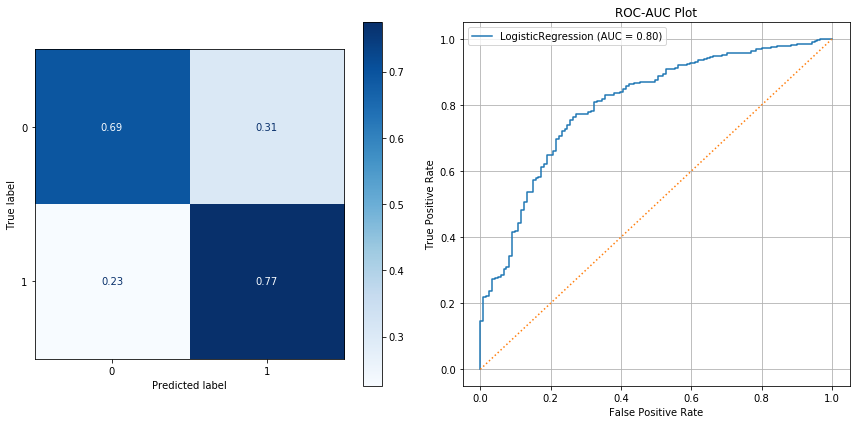

In [49]:
# Fit a new model with the best parameters

best_logreg_params = grid.best_params_
best_logreg_model = LogisticRegression(**best_logreg_params, class_weight = 'balanced')
best_logreg_model.fit(X_train_df, y_train)

# Evaluate model
evaluate_model(best_logreg_model, X_test_df, y_test)

> Accuracy score leaves alot to be desired here, so perhaps Logistic Regression isn't the way to go.

### Decision Tree

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       121
           1       0.96      0.95      0.95       713

    accuracy                           0.92       834
   macro avg       0.84      0.86      0.85       834
weighted avg       0.92      0.92      0.92       834



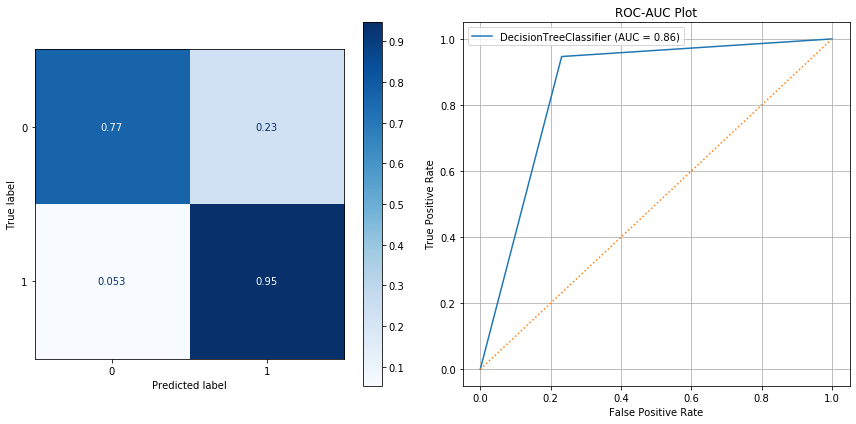

In [36]:
# Instantiate Model
tree = DecisionTreeClassifier(class_weight = 'balanced')

# Fit model
tree.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(tree, X_test_df, y_test)

#### Gridsearch

In [51]:
# Finding the best hyperparamters

estimator = DecisionTreeClassifier(class_weight = 'balanced')
params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, '50', '100'],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 5, 10],
          'max_features': ['auto', 'sqrt', 'log2', None]}

# Fit the gridsearch
grid = GridSearchCV(estimator = estimator,
                    param_grid = params,
                    cv = 3, 
                    n_jobs = -1)
grid.fit(X_train_df, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, '50', '100'],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [52]:
# Checking the results

print(grid.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       121
           1       0.96      0.95      0.95       713

    accuracy                           0.92       834
   macro avg       0.84      0.86      0.85       834
weighted avg       0.92      0.92      0.92       834



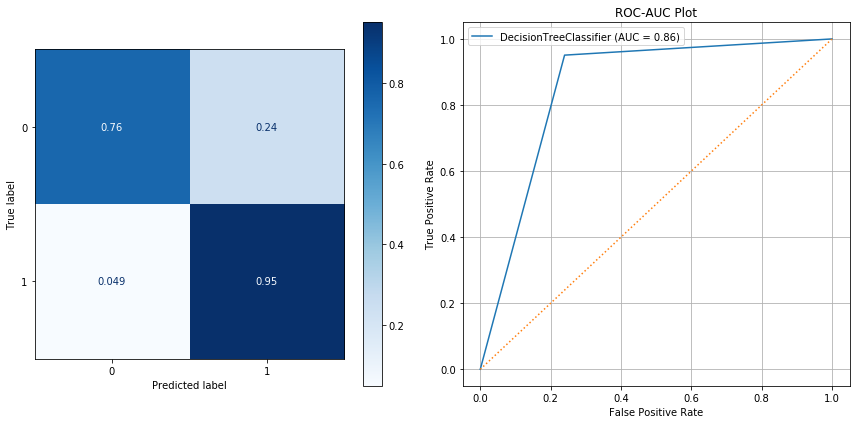

In [56]:
# Fit new model with best parameters

best_tree_params = grid.best_params_
best_tree_model = DecisionTreeClassifier(**best_tree_params, class_weight = 'balanced')
best_tree_model.fit(X_train_df, y_train)

evaluate_model(best_tree_model, X_test_df, y_test)

> Not much of a difference with the gridsearch, but we're looking at a 92% accuracy and 92% weighted recall.  Not too bad here, but I feel like we can do better. 

### Random Forest

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.59      0.72       121
           1       0.93      0.99      0.96       713

    accuracy                           0.93       834
   macro avg       0.93      0.79      0.84       834
weighted avg       0.93      0.93      0.93       834



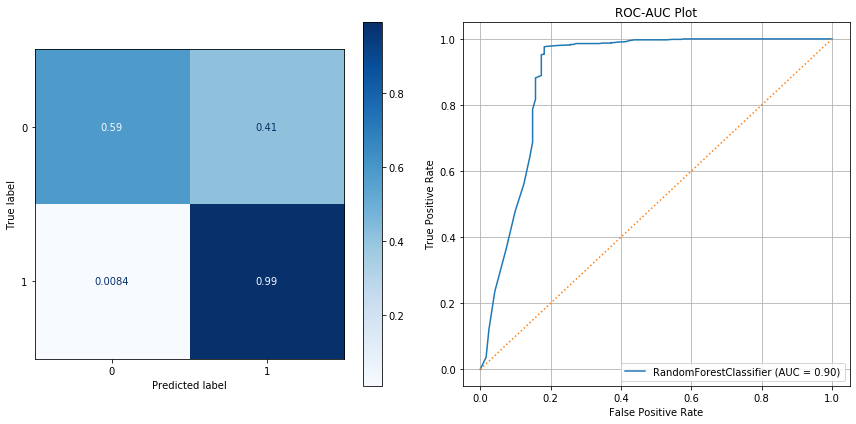

In [38]:
# Instantiate Model 
rf = RandomForestClassifier(class_weight = 'balanced')

# Fit model
rf.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(rf, X_test_df, y_test)

#### Gridsearch

In [57]:
# Finding the best hyperparameters

estimator = RandomForestClassifier(class_weight = 'balanced')
params = {'n_estimators': [100, 200, 500],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 5, 10], 
          'max_features': ['auto', 'sqrt', 'log2']}

# Fit the grid
grid = GridSearchCV(estimator = estimator,
                    param_grid = params,
                    cv = 3, 
                    n_jobs = -1)

grid.fit(X_train_df, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [58]:
# Check the results

print(grid.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       121
           1       0.96      0.98      0.97       713

    accuracy                           0.95       834
   macro avg       0.92      0.87      0.89       834
weighted avg       0.95      0.95      0.95       834



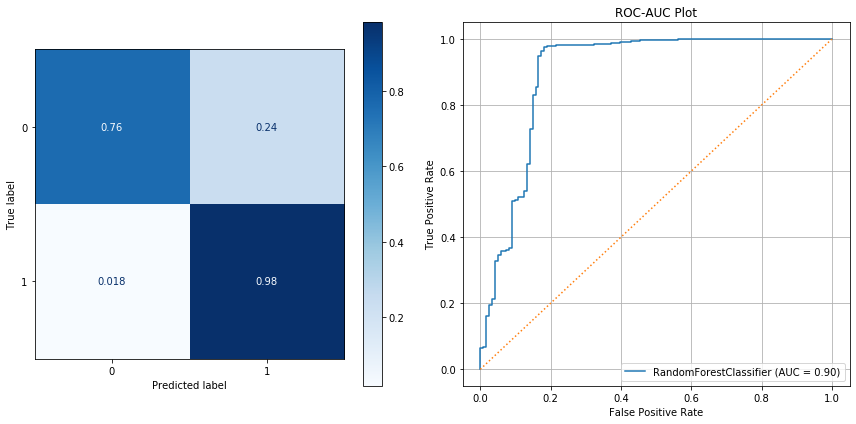

In [59]:
# Fit a new model with best parameters
best_rf_params = grid.best_params_
best_rf_model = RandomForestClassifier(**best_rf_params, class_weight = 'balanced')
best_rf_model.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(best_rf_model, X_test_df, y_test)

> This model performed pretty admirabily with a 95% accuracy and an 95% weighted recall.  Let's see how XGBoost performs before moving on. 

### XGBoost

#### Class Weights for XGBoost

Since there's no class_weight parameter for XGBoost, we need to figure out a value to pass in for the scale_pos_weight.  This parameter acts similarly to class_weights.

In [ ]:
from collections import Counter

counter = Counter(y_train)

estimate = counter[0] / counter[1]

print('Estimate: %.3f' % estimate)

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       121
           1       0.96      0.99      0.97       713

    accuracy                           0.95       834
   macro avg       0.93      0.86      0.89       834
weighted avg       0.95      0.95      0.95       834



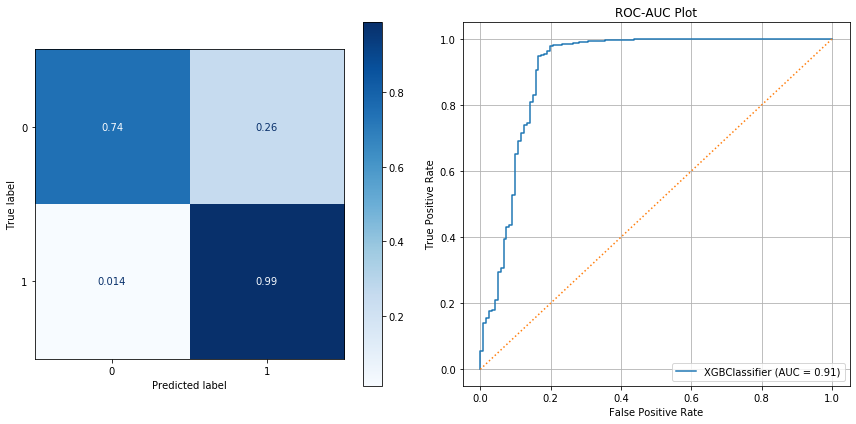

In [39]:
# Instantiate Model
xgb = XGBClassifier()

# Fit model
xgb.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(xgb, X_test_df, y_test)

#### Gridsearch

In [60]:
# Find the best parameters

estimator = XGBClassifier()
params = {'booster': ['gbtree', 'gblinear', 'dart'],
          'eta': [0.3, 0.5, 0.75],
          'gamma': [0, 1, 5],
          'max_depth': [6, 10, 20],
          'min_child_weight': [1, 3], 
          'sampling_method': ['uniform', 'gradient_based'], 
          'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist']}

# Fit the grid
grid = GridSearchCV(estimator = estimator, 
                    param_grid = params, 
                    cv = 3, 
                    n_jobs = -1)
grid.fit(X_train_df, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [0.3, 0.5, 0.75], 'gamma': [0, 1, 5],
                         'max_depth': [6, 10, 20], 'min_child_weight': [1, 3],
                         'sampling_method': ['uniform', 'gradient_based'],
                         'tree_method': ['auto', 'exact', 'approx', 'hist',
                                         'gpu_hist']})

In [61]:
# Check out the results of the gridsearch

print(grid.best_estimator_.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'eta': 0.3, 'sampling_method': 'uniform', 'tree_method': 'auto'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       121
           1       0.96      0.99      0.97       713

    accuracy                           0.95       834
   macro avg       0.93      0.88      0.90       834
weighted avg       0.95      0.95      0.95       834



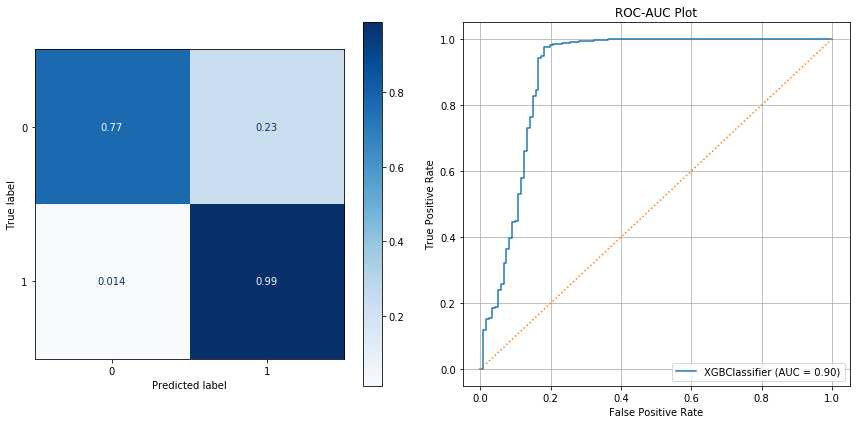

In [62]:
# Fit a new model with the best parameters

best_xgb_params = grid.best_params_
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(best_xgb_model, X_test_df, y_test)

### Stacking Classifier 

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       121
           1       0.97      0.98      0.97       713

    accuracy                           0.96       834
   macro avg       0.93      0.89      0.91       834
weighted avg       0.96      0.96      0.96       834



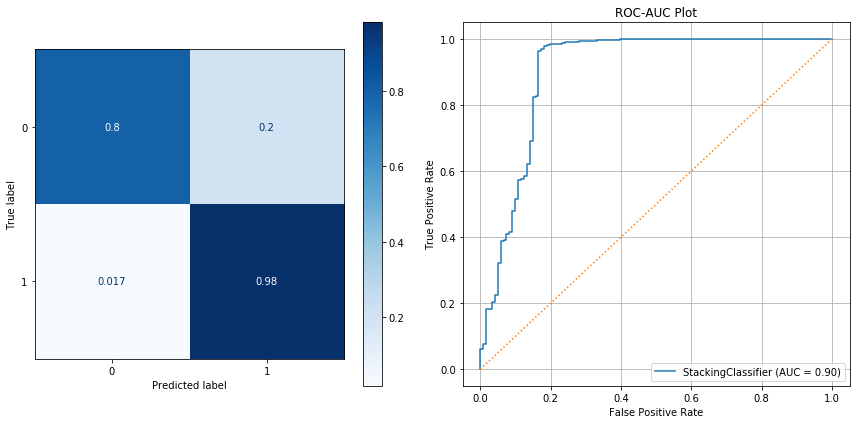

In [77]:
# Let's take the best performing models and put them together into a stacking ensemble.

estimators = [('tree', best_tree_model),
              ('rf', best_rf_model),
              ('xgb', best_xgb_model)]

stack = StackingClassifier(estimators = estimators, cv = 3, n_jobs = -1)
stack.fit(X_train_df, y_train)

# Evaluate model
evaluate_model(stack, X_test_df, y_test)

### Voting Classifier

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       121
           1       0.96      0.98      0.97       713

    accuracy                           0.95       834
   macro avg       0.92      0.88      0.90       834
weighted avg       0.95      0.95      0.95       834



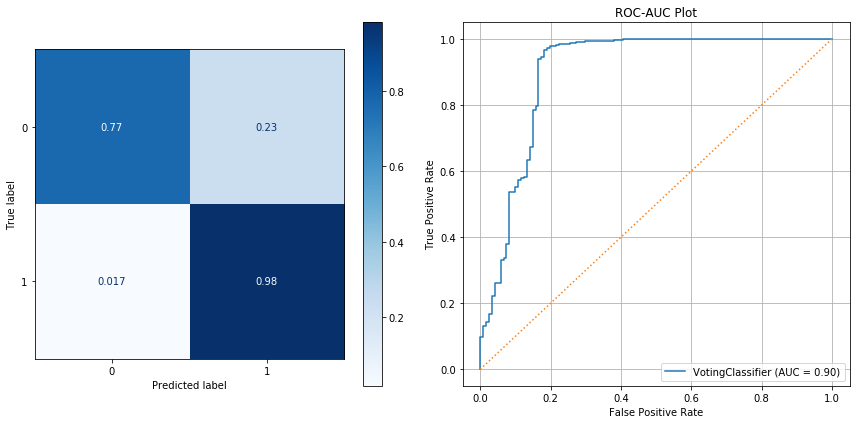

In [83]:
# Let's take the best performing models and put them together into a voting ensemble.

estimators = [('tree', best_tree_model),
              ('rf', best_rf_model),
              ('xgb', best_xgb_model)]

voting = VotingClassifier(estimators = estimators, voting = 'soft', n_jobs = -1)

voting.fit(X_train_df, y_train)

evaluate_model(voting, X_test_df, y_test)

> The best performing model of the various scikit-learn models we experimented with was the Stacking Classifier.

### Neural Network

Putting together a neural network for this may be overkill...but let's give it a shot anyway.

#### Class Weights

In [104]:
from sklearn.utils.class_weight import compute_class_weight

# Dealing with class imbalance

weight_labels = df['churn'].copy()
weights = compute_class_weight('balanced', np.unique(weight_labels), weight_labels)
weights = dict(zip(np.unique(weight_labels), weights))

In [105]:
weights

{0: 3.450310559006211, 1: 0.5847368421052631}

#### Model

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.6779 - accuracy: 0.6261 - val_loss: 0.6512 - val_accuracy: 0.7120
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.6083 - accuracy: 0.5975 - val_loss: 0.4473 - val_accuracy: 0.8240
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.5672 - accuracy: 0.7404 - val_loss: 0.4407 - val_accuracy: 0.8320
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.4857 - accuracy: 0.7999 - val_loss: 0.4793 - val_accuracy: 0.8240
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.4751 - accuracy: 0.8399 - val_loss: 0.5161 - val_accuracy: 0.8147
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.8605 - val_loss: 0.5122 - val_accuracy: 0.8240
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.4448 - accuracy: 0.8548 - val_loss: 0.3831 - val_accuracy: 0.8680
Epoch 

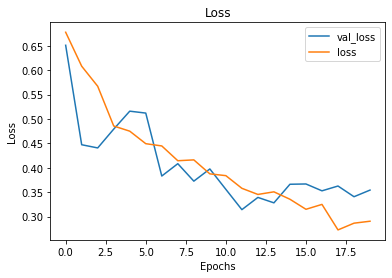

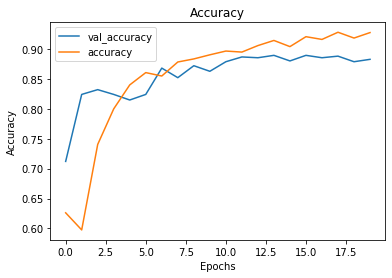

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.79      0.70       121
           1       0.96      0.92      0.94       713

    accuracy                           0.90       834
   macro avg       0.79      0.86      0.82       834
weighted avg       0.91      0.90      0.91       834

 
                 Confusion Matrix
-------------------------------------------------------


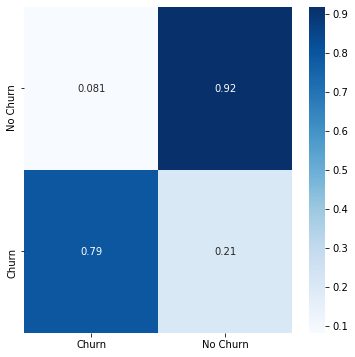

In [118]:
# Model Architecture

# Call the model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim = X_train_df.shape[1], activation = 'tanh'))

# Hidden Layers
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 8, epochs = 20, 
                    validation_split = 0.3, class_weight = weights)

# Evaluate Model
evaluate_network(history, model, X_test_df, y_test)

## Interpret

Though the Stacking Classifier performed the best, the complexity of the model doesn't play well in terms of pulling feature importances or creating SHAP explainer plots.  Due to this issue, we'll be using the next highest performing model, XGBoost, in order to pull the most important features. 

### Feature Importances

In [124]:
# Pull feature importances
features_dict = {'Features': X_train_df.columns, 
                 'Importance': best_xgb_model.feature_importances_}

# Convert to a dataframe
feature_importance = pd.DataFrame(features_dict, columns = ['Features','Importance'])

print(feature_importance.shape)
feature_importance

(70, 2)


,Features,Importance
0,account length,0.021853
1,number vmail messages,0.079702
2,total day minutes,0.090155
3,total day calls,0.024752
4,total day charge,0.000000
...,...,...
65,state_WY,0.000000
66,international plan_no,0.108653
67,international plan_yes,0.000000
68,voice mail plan_no,0.000000


In [126]:
# Removing all features with a 0 importance

for i in feature_importance['Importance']:
    if i == 0:
        feature_importance['Importance'].replace(i, np.nan, inplace = True)
        
feature_importance.dropna(inplace = True)

# Sorting the importances
feature_importance.sort_values(by = ['Importance'], ascending = False, inplace = True)

print(feature_importance.shape)
feature_importance

(28, 2)


,Features,Importance
14,customer service calls,0.128316
66,international plan_no,0.108653
2,total day minutes,0.090155
12,total intl calls,0.089644
1,number vmail messages,0.079702
11,total intl minutes,0.071251
5,total eve minutes,0.064996
46,state_NJ,0.041596
8,total night minutes,0.030682
28,state_ID,0.025746


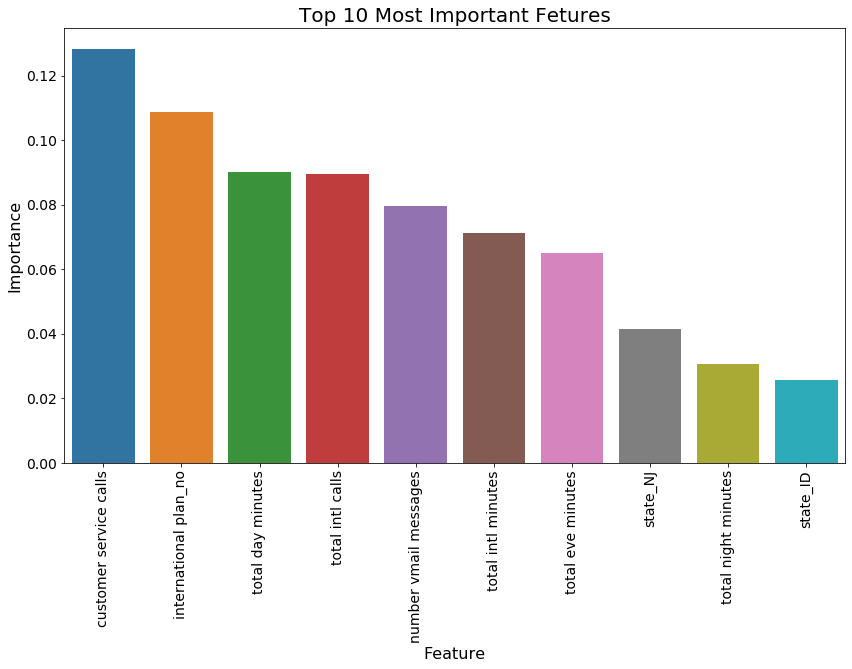

In [134]:
# Let's plot the feature importances

ax = plt.figure(figsize = (14, 8))
ax = sns.barplot(data = feature_importance.head(10), 
                 x = 'Features', y = 'Importance')
ax.set_title('Top 10 Most Important Fetures', fontsize = 20)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Importance', fontsize = 16)
ax.tick_params(labelsize = 14)
plt.xticks(rotation = 90);

### SHAP

In [135]:
# Setting up SHAP

X_shap = shap.sample(X_train_df, 100)
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_shap)

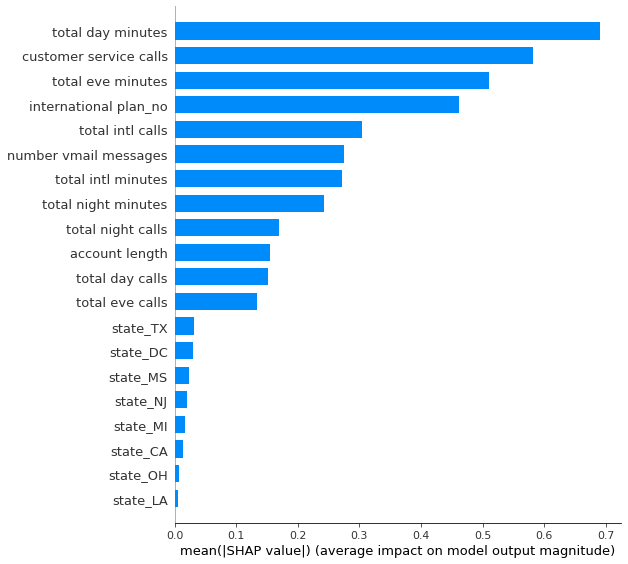

In [136]:
# Plot a Shap Summary Plot

fig = shap.summary_plot(shap_values, X_shap, plot_type = 'bar')

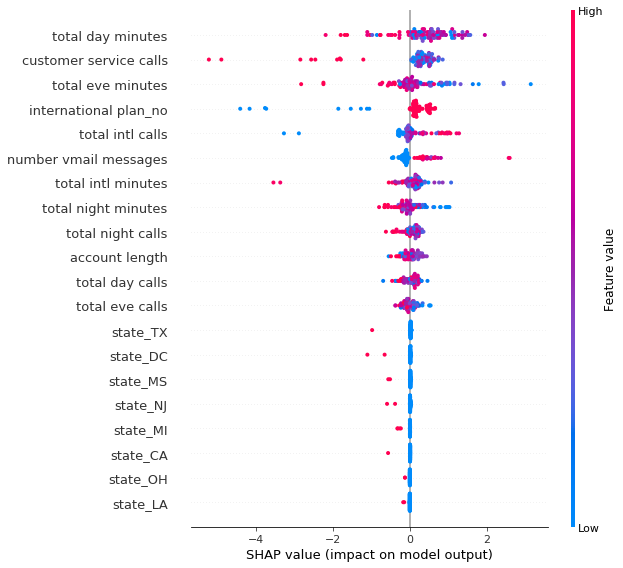

In [137]:
# Another shap plot that shows how each feature affects churn

shap.summary_plot(shap_values, X_shap)

## Conclusion

With so much competition in the telecom market, it's no surprise that many companies have issues with losing customers to competing companies.  Often, it is not 100% clear why these customers drop their current provider to leave for another.  

In this project, we have used data analysis and machine learning to figure out what factors most influence a customer's decision to leave their service provider for a competitor.  

### Results

<b> Throughout the course of this project, we have determined the following features are the most important contributing features to customer churn:</b>
- Total Day Minutes - The total amount of minutes spent on the phone during the day is the most important feature in terms of customer churn, though it affects the rate of churn both positively and negatively fairly evenly.  
- Customer Service Calls - The amount of customer service calls very negatively affects whether or not a customer leaves the company. 
- Total Evening Minutes - Similarly to total day minutes, total evening minutes has proven to be a very important feature but affects churn both positively and negatively to a similar degree. 
- No International Plan - Not having an international plan has a positive effect on keeping a customer. 
- Total International Calls - A caller who makes more international calls is more likely to stick with the company.

### Recommendations

<b> Based on these findings, we can make the following recommendations: </b>
- <b>Improve Customer Service </b>- Customers who make more calls to customer service tend to leave the company.  Based on this, we can infer that they experienced below average customer service experiences.  By improving the customer service protocols, we can prevent many customers from leaving. 
- <b>Don't Push an International Plan</b> - Customers who don't already have an international plan tend to churn less frequently than customers who have the international plan.  If we limit the offer of international plans to only the customers who require it, we can lower the rate of customer churn.
- <b> If a Customer Has the International Plan, Make Sure They Use It</b> - Customers who make more international calls tend to continue their service.  By making sure customers who do actually have international plans feel they are getting the full value of their plan, make sure they use the international calling options.

### Future Work

<b>With more time, we can enhance this project in the following ways:</b><br>
- <b>More Data:</b>  With more data, we can make the models more accurate and can perhaps pull different insights
- <b>Feature Engineering:</b>  We can experiment with some feature engineering and see if we can gain new insights into what features contribute to customer churn.
- <b>Modeling:</b>  We can spend more time fine tuning the models to make them more accurate. 

<center><b><i> Thank you. </i></b></center>